# Example AutoEncoder: Convolutional autoencoder for image denoising



## Introduction

This example demonstrates how to implement a deep convolutional autoencoder
for image denoising, mapping noisy digits images from the MNIST dataset to
clean digits images. This implementation is based on an original blog post
titled [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
by [François Chollet](https://twitter.com/fchollet) and [Santiago L. Valdarrama](https://twitter.com/svpino)

## Setup

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


## Prepare the data

11501568/11490434 [==============================] - 0s 0us/step


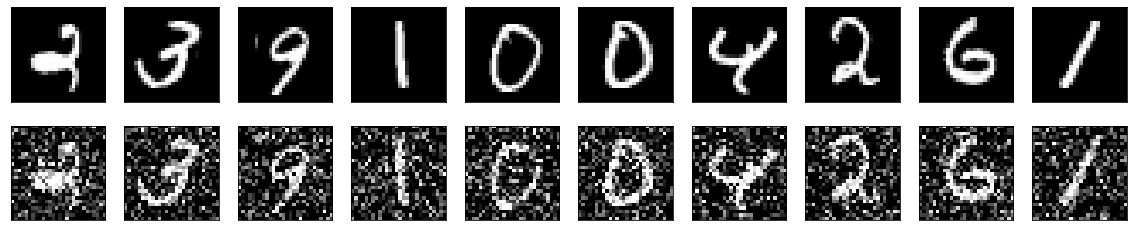

In [2]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

## Build the autoencoder

We are going to use the Functional API to build our convolutional autoencoder.

In [3]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 32)       9248  

Now we can train our autoencoder using `train_data` as both our input data
and target. Notice we are setting up the validation data using the same
format.

In [4]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=5, #should be higher
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/5
469/469 [==============================] - 21s 18ms/step - loss: 0.1362 - val_loss: 0.0741
Epoch 2/5
469/469 [==============================] - 8s 16ms/step - loss: 0.0721 - val_loss: 0.0698
Epoch 3/5
469/469 [==============================] - 8s 16ms/step - loss: 0.0694 - val_loss: 0.0681
Epoch 4/5
469/469 [==============================] - 8s 16ms/step - loss: 0.0681 - val_loss: 0.0673
Epoch 5/5
469/469 [==============================] - 8s 17ms/step - loss: 0.0673 - val_loss: 0.0666


Let's predict on our test dataset and display the original image together with
the prediction from our autoencoder.

Notice how the predictions are pretty close to the original images, although
not quite the same.

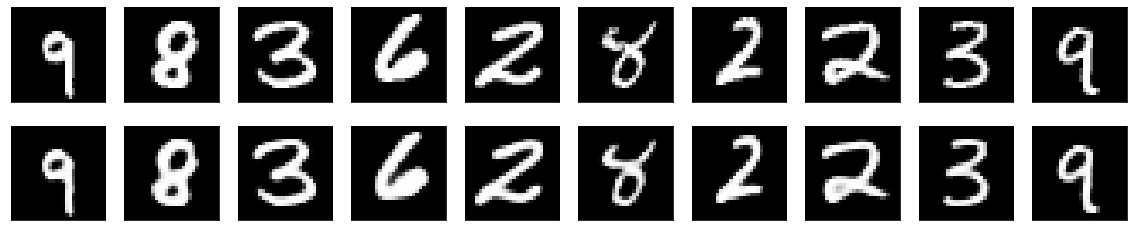

In [5]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

Now that we know that our autoencoder works, let's retrain it using the noisy
data as our input and the clean data as our target. We want our autoencoder to
learn how to denoise the images.

In [7]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=5, #should be more
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/5
469/469 [==============================] - 8s 16ms/step - loss: 0.0886 - val_loss: 0.0878
Epoch 2/5
469/469 [==============================] - 8s 16ms/step - loss: 0.0881 - val_loss: 0.0873
Epoch 3/5
469/469 [==============================] - 8s 16ms/step - loss: 0.0877 - val_loss: 0.0870
Epoch 4/5
469/469 [==============================] - 8s 16ms/step - loss: 0.0874 - val_loss: 0.0869
Epoch 5/5
469/469 [==============================] - 8s 16ms/step - loss: 0.0871 - val_loss: 0.0865


Let's now predict on the noisy data and display the results of our autoencoder.

Notice how the autoencoder does an amazing job at removing the noise from the
input images.

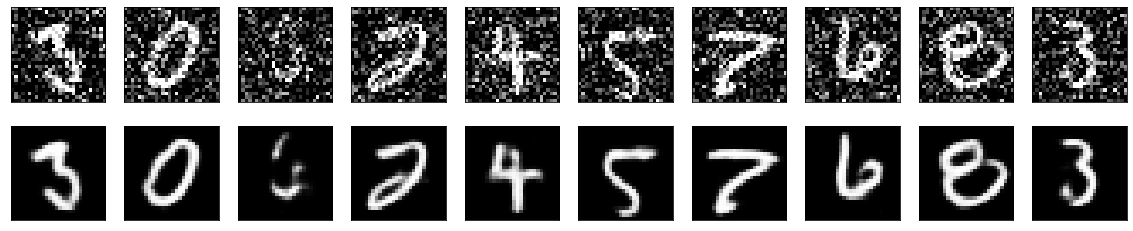

In [8]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)